In [1]:
import os
import glob
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
%%time
datadir = "/work2/jprieto/data/us-famli/save_frame/"
session_paths = glob.glob(f"{datadir}/*")
session_paths[0]

In [4]:
frame_ids = pd.Series([os.path.basename(p).split(".png")[0] for p in session_paths])
frame_ids

0          003f1137-63cc-4047-a265-b4aef597f980_frame_13
1          003f1137-63cc-4047-a265-b4aef597f980_frame_14
2          003f1137-63cc-4047-a265-b4aef597f980_frame_15
3          003f1137-63cc-4047-a265-b4aef597f980_frame_16
4          003f1137-63cc-4047-a265-b4aef597f980_frame_17
                               ...                      
431235    ffea7331-4b73-45b6-9ffb-0028ad7f7a86_frame_641
431236    ffea7331-4b73-45b6-9ffb-0028ad7f7a86_frame_642
431237    ffea7331-4b73-45b6-9ffb-0028ad7f7a86_frame_643
431238    ffea7331-4b73-45b6-9ffb-0028ad7f7a86_frame_644
431239    ffea7331-4b73-45b6-9ffb-0028ad7f7a86_frame_645
Length: 431240, dtype: object

In [5]:
sweep_ids = sorted(set([p.split("_")[0] for p in frame_ids]))
sweep_ids = pd.Series(sweep_ids)
len(sweep_ids)

2470

In [6]:
sweep_ids[0]

'003f1137-63cc-4047-a265-b4aef597f980'

In [7]:
np.random.seed(42)
val_ratio = 0.05
val_size = int(val_ratio * len(sweep_ids))

sweep_ids_shuffled = sweep_ids.sample(frac=1, random_state=42)

validation_ids = set(sweep_ids_shuffled.iloc[:val_size])
testing_ids = set(sweep_ids_shuffled.iloc[val_size:val_size*2])
training_ids = set(sweep_ids_shuffled.iloc[val_size*2:])

assert np.sum((len(training_ids), len(validation_ids), len(testing_ids))) == sweep_ids.shape[0]
len(training_ids), len(validation_ids), len(testing_ids)

(2224, 123, 123)

In [8]:
training, validation, testing = [],[],[]

for fid in tqdm(frame_ids):

    sid = fid.split("_")[0]
    
    if sid in training_ids:
        training.append(fid)
    elif sid in validation_ids:
        validation.append(fid)
    else:
        testing.append(fid)

training = pd.Series(training)
validation = pd.Series(validation)
testing  = pd.Series(testing)

100%|██████████| 431240/431240 [00:00<00:00, 1496696.44it/s]


In [9]:
assert np.sum((len(training), len(validation), len(testing))) == frame_ids.shape[0]
len(training), len(validation), len(testing)

(387722, 22933, 20585)

In [10]:
training.to_csv("../split-keys/usf-train_keys.txt", header=None, index=None)
validation.to_csv("../split-keys/usf-val_keys.txt", header=None, index=None)
testing.to_csv("../split-keys/usf-test_keys.txt", header=None, index=None)

### Anomalous Paths

In [13]:
from monai.transforms import LoadImage, SaveImage
loader = LoadImage()
saver = SaveImage(output_ext='.png')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 17:38:29.046884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 17:38:29.324407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 17:38:29.366893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 17:38:29.770440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to 

In [17]:
fnames = glob.glob(f"{img_paths[1]}/*/*")
len(fnames)

438

In [22]:
fnames[-1]

'/work2/jprieto/data/us-famli/extract_frames_blind_sweeps/dataset_C1_cines_masked_resampled_256_spc075_uuids/003793fb-2ddf-4926-8195-f5f6de894655/7617ea44-1175-4ada-9f11-700f03fc87cb/99.nrrd'

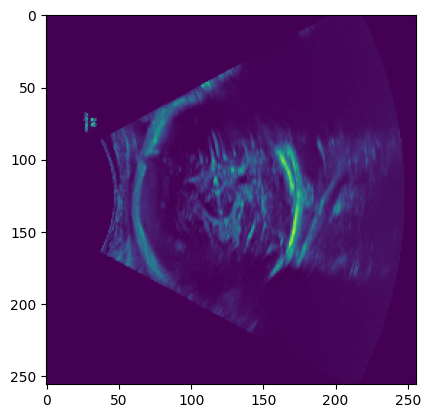

In [18]:
ximg = loader(fnames[0])
plt.imshow(ximg)

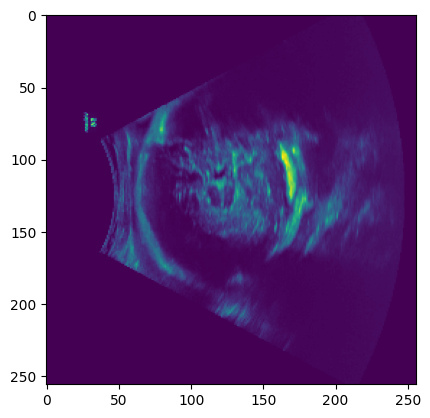

In [19]:
ximg = loader(fnames[-1])
plt.imshow(ximg)

In [4]:
%%time
ano_datadir = "/work2/jprieto/data/us-famli/anomalous/"
savedir = "/work2/amahmood/data/us-famli/anomalous/"
anopaths = glob.glob(f"{ano_datadir}/*")

for fp in tqdm(anopaths):
    sid = os.path.basename(fp).split(".nrrd")[0]
    x = loader(fp)
    x = x.mean(0)
    saver(x, filename=f"{savedir}/{sid}")
    break

NameError: name 'tqdm' is not defined

In [91]:
z = loader(f"{savedir}/{sid}.png")
z.shape

torch.Size([256, 256])

In [8]:
x = loader(anopaths[0])
x.shape

torch.Size([3, 256, 256, 1])

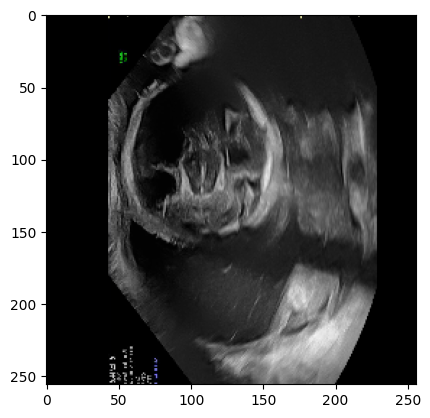

In [21]:
x = loader(anopaths[1010])
z = x.permute(3, 1, 2, 0)[0] / 256
plt.imshow(z)

In [ ]:
x = loader(anopaths[11])
z = x.permute(3, 1, 2, 0)[0] / 256
plt.imshow(z)

In [64]:
z = x.permute(1,0,2,3).reshape(256,256*3)

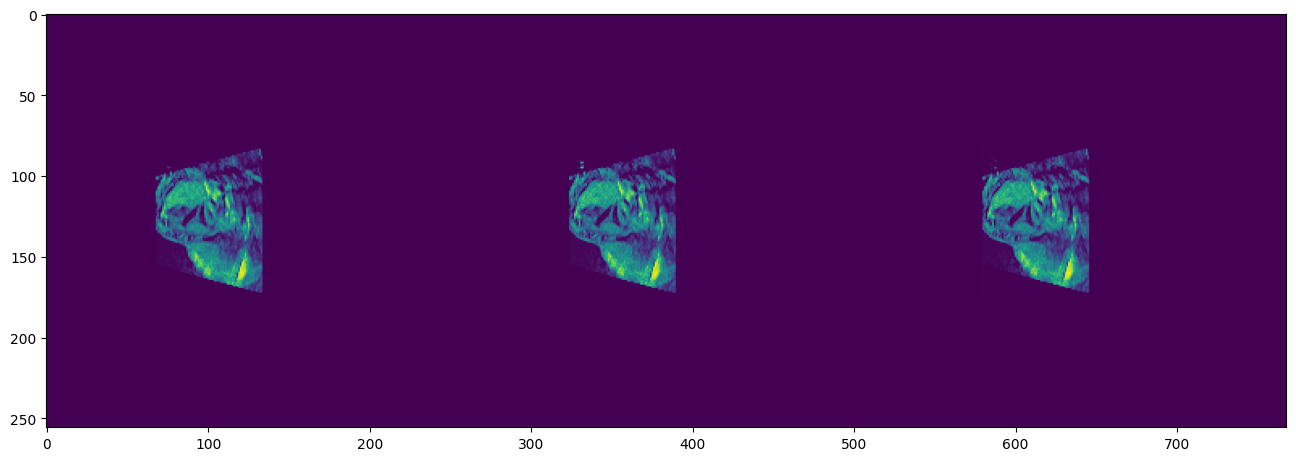

In [65]:
plt.figure(figsize=(16,9))
plt.imshow(z)

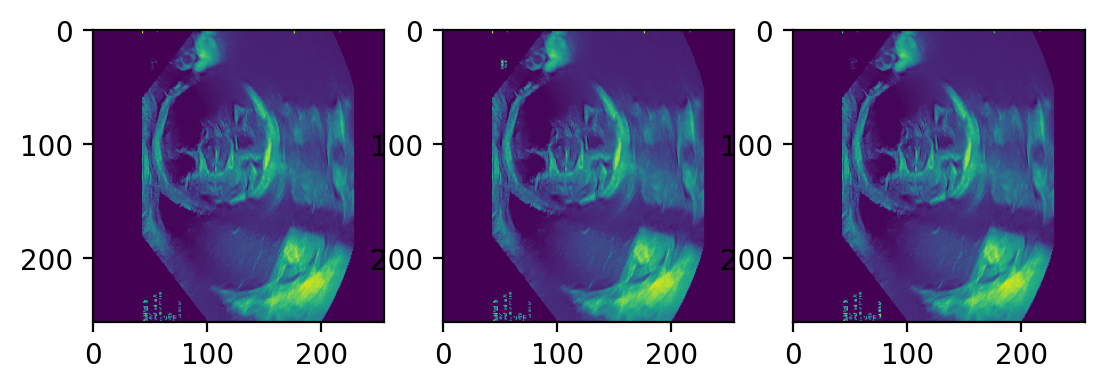

In [31]:
fig, axs = plt.subplots(1,3,dpi=200)
axs[0].imshow(x[0,:,:,0])
axs[1].imshow(x[1,:,:,0])
axs[2].imshow(x[2,:,:,0])

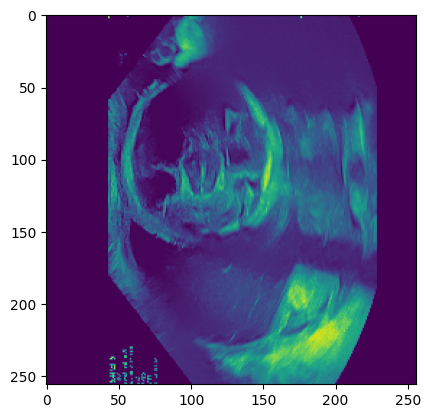

In [33]:
plt.imshow(x[0,:,:,0])

### Experiments with loaders and transforms

In [12]:
from monai.transforms import LoadImage, TorchVision, EnsureChannelFirst, RandSmoothFieldAdjustIntensity
ensure = EnsureChannelFirst()
loader = LoadImage(converter=lambda image: image.convert("L"))
resize = TorchVision("Resize", size=(256, 256))
crop = TorchVision("CenterCrop", size=(400, 400))
loader, resize

2024-11-22 19:49:16.335456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 19:49:16.357654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 19:49:16.364192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 19:49:16.380469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(<monai.transforms.io.array.LoadImage at 0x7f80ef853970>,
 <monai.transforms.utility.array.TorchVision at 0x7f80ef8537f0>)

In [13]:
for p in img_paths[-1000:-1:100]:
    x = loader(p)
    print(x.shape)
#     x = resize(x[:1])
#     print(x.std())
    break

torch.Size([644, 560])


In [14]:
ensure(x).shape

torch.Size([1, 644, 560])

In [15]:
xbig = ensure(loader(img_paths[500]))/255
xsmall = ensure(loader(img_paths[-500]))/255
xbig.shape, xsmall.shape

(torch.Size([1, 672, 560]), torch.Size([1, 410, 512]))

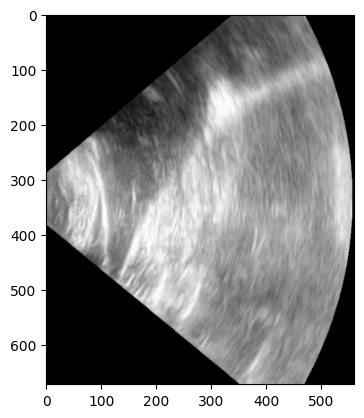

In [220]:
plt.imshow(xbig[0], cmap='gray')

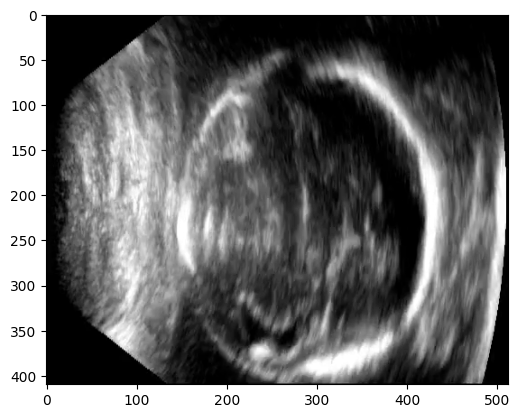

In [223]:
plt.imshow(xsmall[0], cmap='gray')

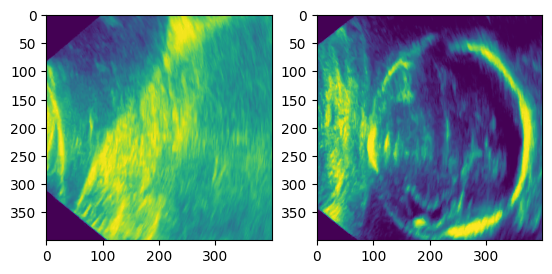

In [226]:
fig, axs = plt.subplots(1,2,)
axs[0].imshow(crop(xbig)[0])
axs[1].imshow(crop(xsmall)[0])

In [288]:
trans = RandSmoothFieldAdjustIntensity(spatial_size=(400,400), rand_size=(200,200), prob=1.0, gamma=(0.8, 1.0))

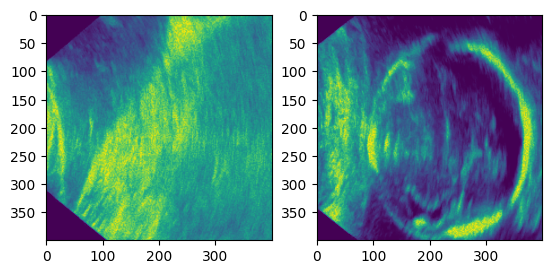

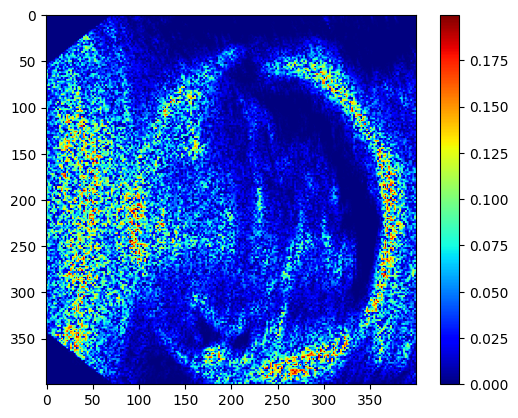

In [289]:
fig, axs = plt.subplots(1,2,)
axs[0].imshow(trans(crop(xbig))[0])
axs[1].imshow(trans(crop(xsmall))[0])
plt.show()
z=crop(xsmall)-trans(crop(xsmall),)
plt.imshow(z[0],  cmap="jet");plt.colorbar()

In [35]:
from sade.datasets.loaders import get_dataloaders
from sade.configs.ve import usf_config_baseline


config = usf_config_baseline.get_config()
dataloaders, datasets = get_dataloaders(config)

In [83]:
import torch
from tqdm import tqdm

In [37]:
val_dl = dataloaders[1]
val_ds = datasets[1]

In [76]:
val_batch = torch.stack([x["image"][:1] for x in val_ds[::100]])
val_batch.shape

torch.Size([230, 1, 256, 256])

In [43]:
bsz = val_batch.shape[0]

In [85]:
dists = []
stds = []
for xbatch in tqdm(val_ds[1::100]):
    x = xbatch["image"][:1]
    stds.append(x.std().numpy())
    diff = (x - val_batch).reshape(bsz, -1)
    dists.extend(torch.linalg.norm(diff, dim=1).numpy())

100%|██████████| 230/230 [00:21<00:00, 10.56it/s]


In [90]:
val_batch.min(), x.min()

(metatensor(-1.), metatensor(-1.))

In [93]:
torch.movedim(val_batch, 1, val_batch.ndim-1).shape

torch.Size([230, 256, 256, 1])

In [88]:
dists = np.asarray(dists)
stds = np.asarray(stds)
stds.mean(), np.median(dists), np.quantile(dists, 0.99)

(0.5049191, 483.8762, 633.2168530273437)

In [94]:
import matplotlib.pyplot as plt



torch.Size([8, 256, 256, 1])

In [103]:
val_batch = torch.stack([x["image"] for x in val_ds[:8]])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [108]:
img = torch.movedim(val_batch[:8], 1, val_batch.ndim-1).cpu().numpy()
img.shape

(8, 256, 256, 3)

In [115]:
z = np.transpose(img.reshape(4,2,256, 256, 3), (0,2,1,3,4)).reshape(256*4,256*2, 3)
z -= z.min()
z /=z.max()
z.shape

(1024, 512, 3)

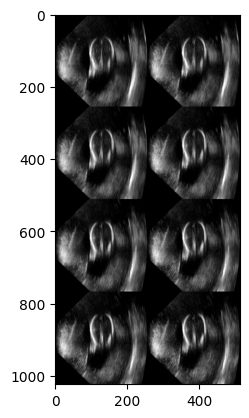

In [116]:
plt.imshow(z)

In [157]:
sample = np.load("/ASD/ahsan_projects/us-families/baseline-deep/samples/iter_500000//sample.np")
sample.shape

(8, 256, 256, 3)

In [158]:
sample.max()

1.1713915

In [159]:
((sample+1) / 2).min()

0.41172355

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


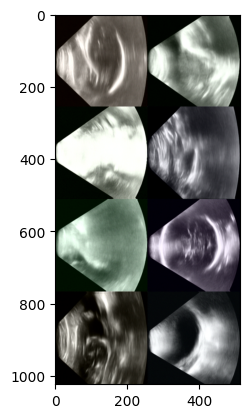

In [160]:
z = np.transpose(sample.reshape(4,2,256, 256, 3), (0,2,1,3,4)).reshape(256*4,256*2, 3)
# z -= z.min()
# z /=z.max()
plt.imshow(z)

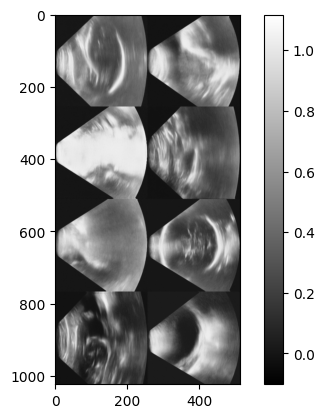

In [161]:
plt.imshow(z.mean(-1), cmap="gray")
plt.colorbar()

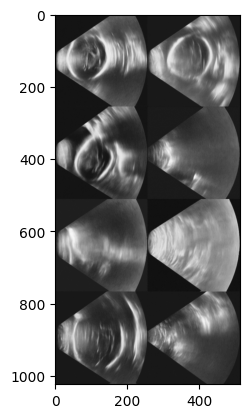

In [156]:
plt.imshow(z.mean(-1), cmap="gray")
plt.savefig("grayscale.png", dpi=150)

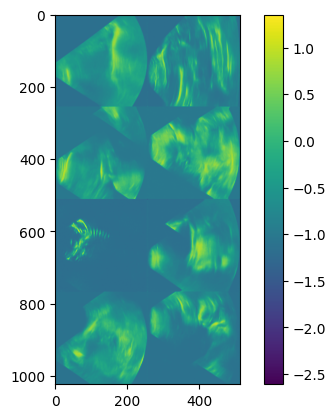

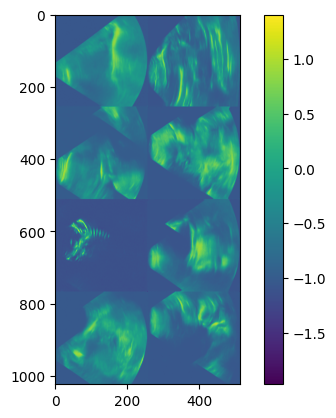

In [136]:
plt.imshow(z[...,0]);plt.colorbar()
plt.show()
plt.imshow(z[...,1]); plt.colorbar()

### Exploring Discrete Wavelets


In [21]:
xcrop = crop(xsmall).unsqueeze(0).contiguous().cuda()
xcrop.shape

torch.Size([1, 1, 400, 400])

In [71]:
import torch
from pytorch_wavelets import DTCWTForward, DTCWTInverse
xfm = DTCWTForward(J=2, biort='near_sym_b', qshift='qshift_b').cuda()
ifm = DTCWTInverse(biort='near_sym_b', qshift='qshift_b').cuda()

In [72]:
%time Yl, Yh = xfm(xcrop)
Y = ifm((Yl, Yh))
Y.shape

CPU times: user 10.9 ms, sys: 500 µs, total: 11.4 ms
Wall time: 10.5 ms


torch.Size([1, 1, 400, 400])

In [73]:
Yh[0].dtype

torch.float32

In [74]:
for h in Yh:
    print(h.shape)

torch.Size([1, 1, 6, 200, 200, 2])
torch.Size([1, 1, 6, 100, 100, 2])


In [77]:
Yl.shape

torch.Size([1, 1, 200, 200])

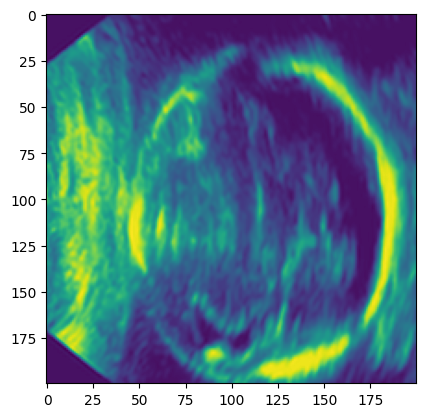

In [76]:
plt.imshow(Yl.cpu()[0,0])

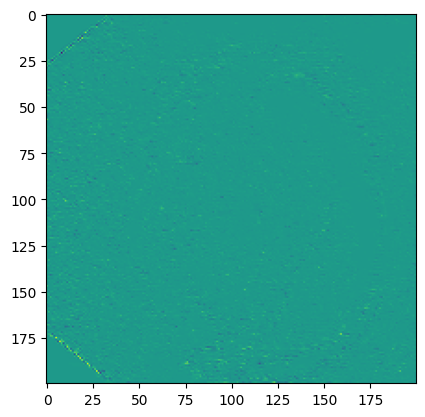

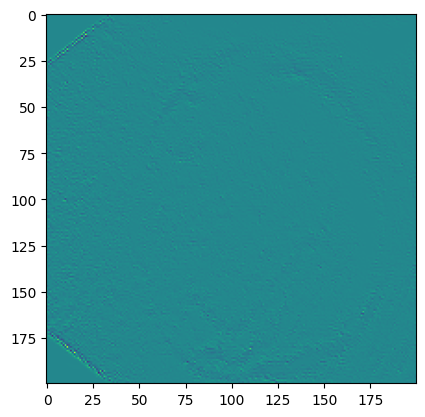

In [78]:
plt.imshow(Yh[0][0,0,0,:,:,0].cpu())
plt.show()
plt.imshow(Yh[0][0,0,0,:,:,1].cpu())

In [88]:
from pytorch_wavelets import DWTForward, DWTInverse
xfm = DWTForward(J=2, wave='db3', mode='periodization').cuda()
ifm = DWTInverse(wave='db3', mode='periodization').cuda()

In [89]:
%time Yl, Yh = xfm(xcrop)
Yl.shape

CPU times: user 3.87 ms, sys: 451 µs, total: 4.32 ms
Wall time: 3.33 ms


torch.Size([1, 1, 100, 100])

In [90]:
Y = ifm((Yl, Yh))
torch.isclose(xcrop, Y, atol=1e-5).all()
Y.shape

torch.Size([1, 1, 400, 400])

In [91]:
for h in Yh:
    print(h.shape)
Yl.shape

torch.Size([1, 1, 3, 200, 200])
torch.Size([1, 1, 3, 100, 100])


torch.Size([1, 1, 100, 100])

torch.Size([1, 1, 100, 100])

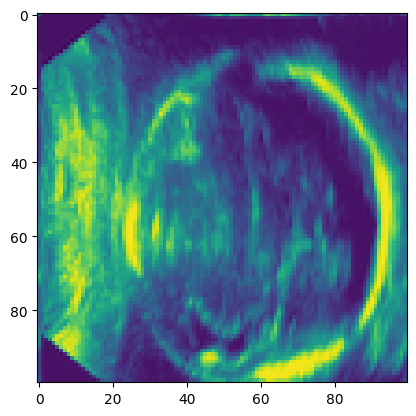

In [92]:
plt.imshow(Yl.cpu()[0,0])
Yl.shape

In [107]:
z = Yh[0][0,0].permute(1,2,0).reshape(200, 200*3)
z.shape

torch.Size([200, 600])

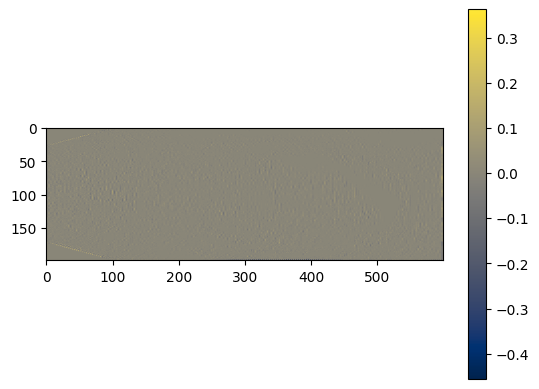

In [108]:
plt.imshow(z.cpu(), cmap='cividis')
plt.colorbar()

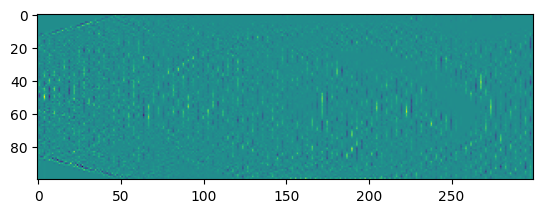

In [98]:
z = Yh[1][0,0].permute(1,2,0).reshape(100, 100*3)
plt.imshow(z.cpu())

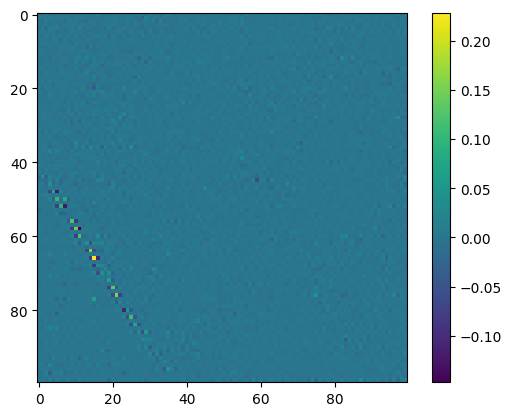

In [124]:
zr = Yh[0][0,0].reshape(12,100,100,)
plt.imshow(zr[-1].cpu())
plt.colorbar()

In [126]:
zm = zr.reshape(3,200,200,)
zm.shape

torch.Size([3, 200, 200])

In [127]:
torch.isclose(Yh[0][0,0], zm).all()

metatensor(True, device='cuda:0')

In [120]:
zr = zr.permute(1,2,0).reshape(100, 100*12)

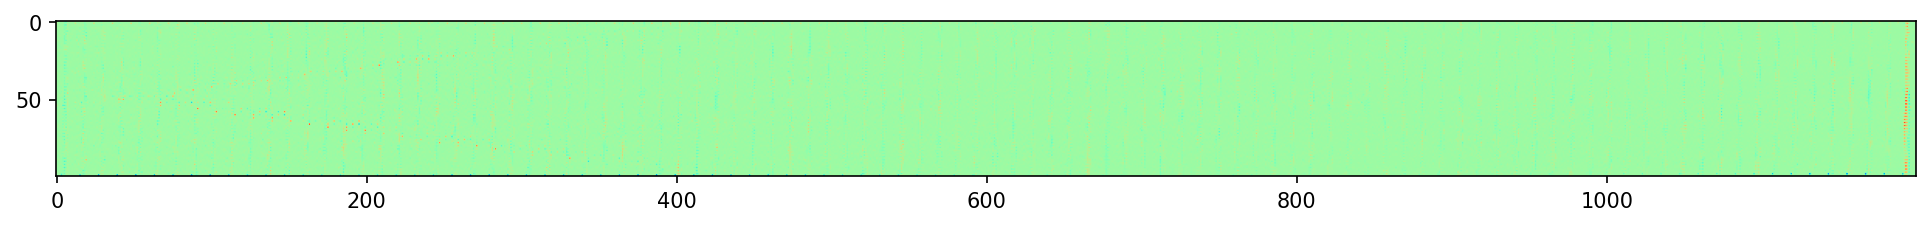

In [122]:
plt.figure(figsize=(16,12), dpi=150)
plt.imshow(zr.cpu(), cmap='rainbow')